In [1]:
#Benchmark of PCA vs LSTM autoencoder for encoding DNA sequences

import numpy as np
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector

def generate_dna_sequences(num_sequences, sequence_length):
    nucleotides = ['A', 'C', 'G', 'T']
    sequences = []
    for _ in range(num_sequences):
        sequence = ''.join(random.choices(nucleotides, k=sequence_length))
        sequences.append(sequence)
    return sequences

# Generate 10000 DNA sequences of length 50
sequences = generate_dna_sequences(num_sequences=10000, sequence_length=50)

# Define a mapping from nucleotides to numerical values
nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

# Convert sequences to numerical format using one-hot encoding
def one_hot_encoding(sequences, nucleotide_map):
    num_sequences = len(sequences)
    sequence_length = len(sequences[0])
    encoded_sequences = np.zeros((num_sequences, sequence_length, 4))
    for i, sequence in enumerate(sequences):
        for j, nucleotide in enumerate(sequence):
            encoded_sequences[i, j, nucleotide_map[nucleotide]] = 1
    return encoded_sequences

encoded_sequences = one_hot_encoding(sequences, nucleotide_map)

#Define edit distance function
def edit_distance(str1, str2):
    m, n = len(str1), len(str2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    return dp[m][n]

In [17]:
# Step 2: Define the autoencoder model
input_seq = Input(shape=(50, 4))

# Encoder
encoded = LSTM(32)(input_seq)
encoded_2=Dense(100)(encoded)

# Decoder
decoded = RepeatVector(50)(encoded_2)
decoded = LSTM(4, return_sequences=True)(decoded)

autoencoder = Model(input_seq, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

# Train the model
autoencoder.fit(encoded_sequences, encoded_sequences, epochs=50, batch_size=32)

# Now the model is trained and ready to be used for autoencoding gene sequences

Epoch 1/50
313/313 [==============================] - 6s 9ms/step - loss: 1.4254
Epoch 2/50
313/313 [==============================] - 3s 8ms/step - loss: 1.3615
Epoch 3/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3559
Epoch 4/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3547
Epoch 5/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3473
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 1.3450
Epoch 7/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3401
Epoch 8/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3407
Epoch 9/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3373
Epoch 10/50
313/313 [==============================] - 3s 9ms/step - loss: 1.3362
Epoch 11/50
313/313 [==============================] - 4s 11ms/step - loss: 1.3344
Epoch 12/50
313/313 [==============================] - 2s 8ms/step - loss: 1.3291
Epoch 13/50
313/313 [==

In [18]:
# Define the encoder model
encoder_model = Model(input_seq, encoded)

# Encode the sequences
encoded_output = encoder_model.predict(encoded_sequences)

313/313 [==============================] - 1s 2ms/step


In [35]:
from sklearn.metrics.pairwise import cosine_similarity


def calculate_cosine_similarity(enc_seq_1):
    similarities = cosine_similarity(enc_seq_1, encoded_output)
    return similarities

# Assuming seq_1 is your sequence, reshape it to 2 dimensions if needed
seq_1 = [encoded_output[0]]

# Calculate cosine similarity
cosine_sim = calculate_cosine_similarity(seq_1)

# Get indices sorted in descending order
sorted_indices = np.argsort(cosine_sim[0])
sorted_sequences=np.array(sequences)[sorted_indices]

In [36]:
distances = []

for i in sorted_sequences[0:1000]:
    distances.append(edit_distance(sequences[0],i))

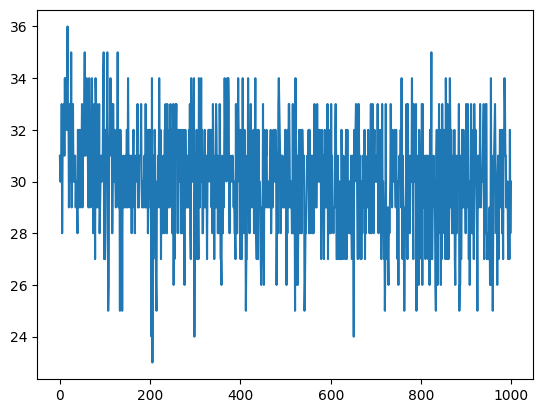

In [37]:
import matplotlib.pyplot as plt

plt.plot(distances)

In [28]:
from sklearn.decomposition import PCA

reshaped_encoded_sequences = encoded_sequences.reshape(encoded_sequences.shape[0], -1)

# Initialize PCA with desired number of components
pca = PCA(n_components=32)  # Set the number of components as desired

# Fit PCA to the data
pca.fit(reshaped_encoded_sequences)

# Transform the data to the reduced dimensionality
encoded_output_pca = pca.transform(reshaped_encoded_sequences)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between centroid and sequences
def calculate_cosine_similarity(enc_seq_1):
    similarities = cosine_similarity(enc_seq_1, encoded_output_pca)
    return similarities

# Reshape the encoded sequences to 2D if needed
reshaped_encoded_sequences_in = encoded_sequences.reshape(encoded_sequences.shape[0], -1)
# Transform the first encoded sequence using PCA
seq_1 = pca.transform(reshaped_encoded_sequences_in[0].reshape(1, -1))

# Calculate cosine similarity
cosine_sim = calculate_cosine_similarity(seq_1)

print("Cosine similarity:", cosine_sim)

Cosine similarity: [[ 1.         -0.03941185 -0.02740466 ... -0.23351411  0.09225051
   0.06441457]]


In [30]:
sorted_indices = np.argsort(cosine_sim[0])
sorted_sequences=np.array(sequences)[sorted_indices]

In [33]:
distances = []

for i in sorted_sequences[0:1000]:
    distances.append(edit_distance(sequences[0],i))

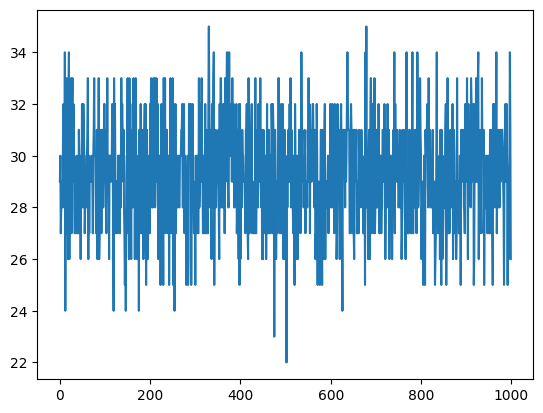

In [34]:
plt.plot(distances)